# <center>Amyloid Positivity</center>

### <center>Alex Konrad</center>

My entry for the Spring 2020 UCI ML Community Hackathon.

# <center>What I was interested in</center>

## <center>Dataset</center>

* Important medical dataset
* Lots of causally interrelated variables
* Combination of biomarkers and psychological measurements

## <center>Techniques</center>

* Probabilistic programming in Stan/BUGS
* Applications of graphical models

### <center>References</center>

* Data Analysis Using Regression and Multilevel/Hierarchical Models by Gelman and Hill
* Bayesian Cognitive Analysis by Lee and Wagenmakers

In [1195]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux

In [1336]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import norm
from theano import tensor as tt
from scipy import stats
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import lars_path
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [1337]:
sns.set_style('ticks')
sns.set_context('talk', font_scale=1)
sns.set_palette('Dark2')

In [1338]:
D = pd.read_csv('./ADNIAVLTAmyloidClassification.csv')
dct = pd.read_csv('./ADNIAVLTAmyloidClassificationDictionary.csv')

In [1339]:
D.loc[D.genotype < 3, 'genotype'] = 1
D.loc[(D.genotype > 1) & (D.genotype < 5), 'genotype'] = 2
D.loc[D.genotype > 4, 'genotype'] = 3

In [1340]:
D.loc[D.dx == 2, 'dx'] = 0
D.loc[D.dx == 1, 'dx'] = 0
D.loc[D.dx == 3, 'dx'] = 1

In [1341]:
D.loc[D.abeta6mcut == 2, 'abeta6mcut'] = 0

In [1342]:
D.loc[D.t6sum < 0, 't6sum'] = 0
D.loc[D.t7sum < 0, 't7sum'] = 0

In [1343]:
D.loc[D.sex == 2, 'sex'] = 0

In [1344]:
D['ifr'] = D.t1sum + D.t2sum + D.t3sum + D.t4sum + D.t5sum + D.t6sum + D.t7sum

D.drop(['t1sum', 't2sum', 't3sum', 't4sum', 't5sum', 't6sum', 't7sum'], axis=1, inplace=True)
D.drop(['wordlist'], axis=1, inplace=True)

In [1345]:
D.loc[D.drec_hits < 0, 'drec_fa'] = 0
D.loc[D.drec_fa < 0, 'drec_fa'] = 0

half_hit = 0.5 / 15
half_fa = 0.5 / 15

hit_rate = D.drec_hits / 15
hit_rate.loc[hit_rate >= 1] = 1 - half_hit
hit_rate.loc[hit_rate <= 0] = half_hit

fa_rate = D.drec_fa / 15
fa_rate.loc[fa_rate >= 1] = 1 - half_fa
fa_rate.loc[fa_rate <= 0] = half_fa

D['hit_rate'] = hit_rate
D['fa_rate'] = fa_rate

In [1417]:
def phi(x):
    return (.5 * pm.math.erf(x / pm.math.sqrt(2))) + .5

## <center>Signal Detection Theory</center>

* Ideal for forced choice experiments with two alternatives
* Every choice the subject makes is either a "hit", "false alarm", "miss", or a "correct rejection"

* All trials are generated from a Gaussian mixture of "signal" and "noise"
* The subject can respond to a "signal" trial with either a "hit" or a "miss"
* The subject can respond to a "noise" trial with either a "false alarm" or a "correct rejection"

Lee and Wagenmakers 2013


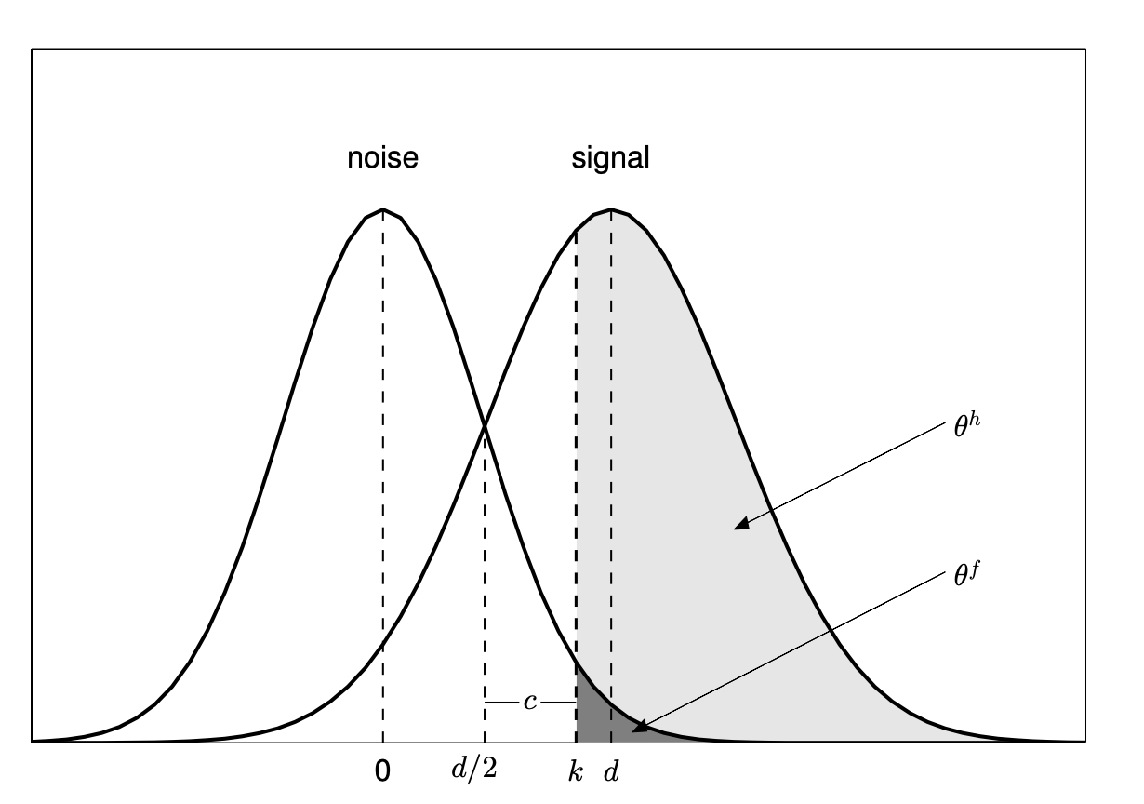

In [1430]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("sdt.png"))
plt.axis('off')
print("Lee and Wagenmakers 2013")

Lee and Wagenmakers 2013


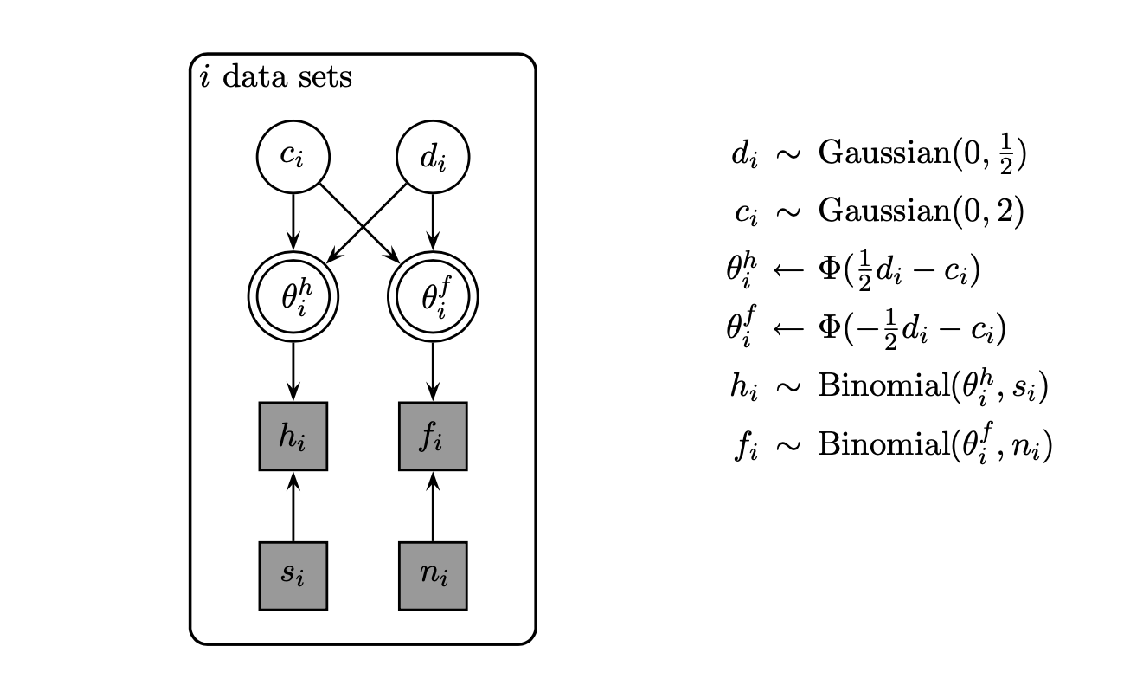

In [1429]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("gm.png"))
plt.axis('off')
print("Lee and Wagenmakers 2013")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Bias, Discriminability]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 508.33draws/s]
/Users/alex/miniconda3/envs/cs273a/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/alex/miniconda3/envs/cs273a/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/alex/miniconda3/envs/cs273a/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

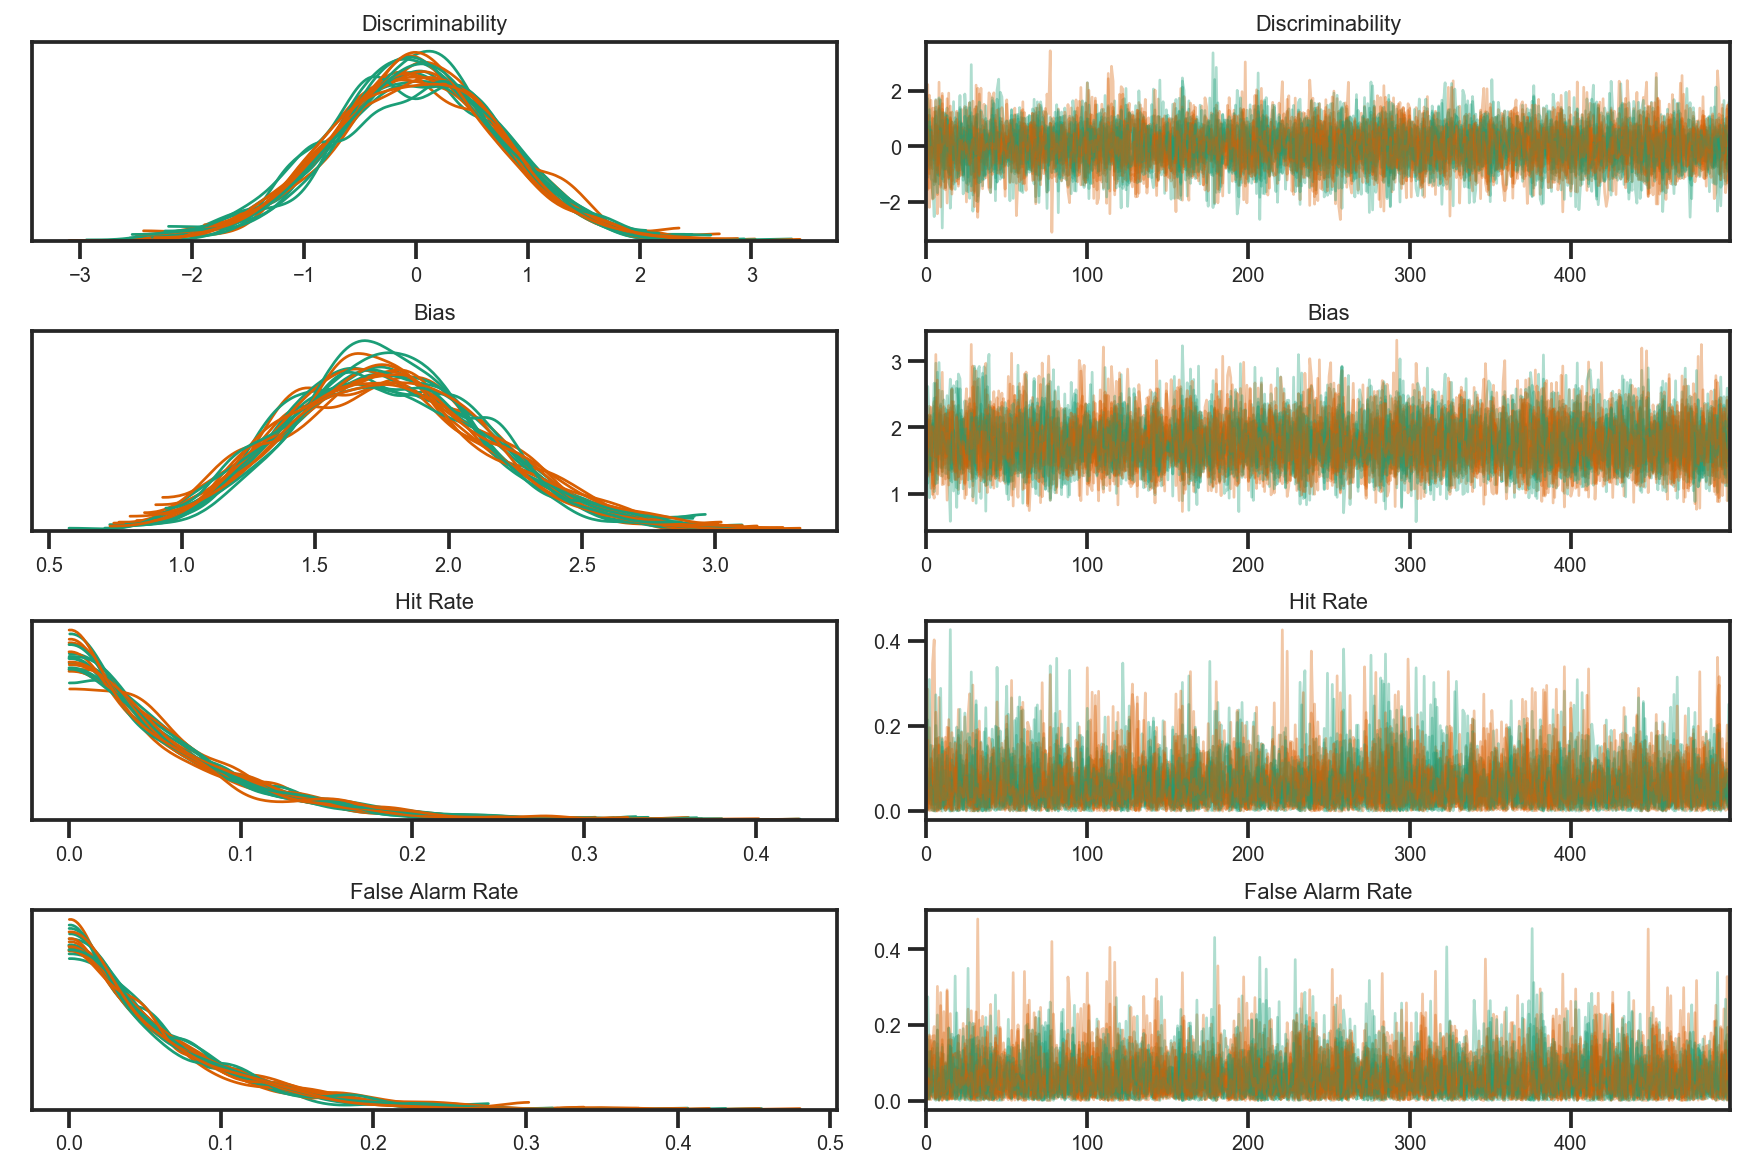

In [1311]:

k=10 # D.shape[0]
with pm.Model() as model1:
    discriminability = pm.Normal('Discriminability', mu=0, tau=.5, shape=k)
    bias = pm.Normal('Bias', mu=0, tau=2, shape=k)
    
    theta_h = pm.Deterministic('Hit Rate', Phi((.5 * discriminability) - bias))
    theta_f = pm.Deterministic('False Alarm Rate', Phi(-(.5 * discriminability) - bias))
    
    N = np.ones_like(D.drec_hits) * 15

    hit_rate = pm.Binomial('hit_rate', p=theta_h, n=[15]*k, observed=D.hit_rate[:k])
    fa_rate = pm.Binomial('fa_rate', p=theta_f, n=[15]*k, observed=D.fa_rate[k])
    
    trace1=pm.sample(init='adapt_diag')

burnin=0    
pm.traceplot(trace1[burnin:], 
             varnames=['Discriminability', 'Bias', 'Hit Rate', 'False Alarm Rate']);

In [ ]:
# TODO: Make hierarchical model
# with pm.Model() as model1:
#     di = pm.Normal('Discriminability', mu=0, tau=.5, shape=k)
#     ci = pm.Normal('Bias', mu=0, tau=2, shape=k)
    
#     thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
#     thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))
    
#     N = np.ones_like(D.drec_hits) * 15
    
#     his = [],
#     fis = []

#     hi = pm.Binomial('hi', p=thetah, n=[15]*k, observed=D.hit_rate[:k])
#     fi = pm.Binomial('fi', p=thetaf, n=[15]*k, observed=D.fa_rate[k])
    
#     trace1=pm.sample(init='adapt_diag')

In [1414]:
probit = norm.ppf
probit_hit = probit(D.hit_rate)
probit_fa = probit(D.fa_rate)
D['d'] = probit_hit - probit_fa
D['beta'] = np.exp((probit_hit**2 - probit_fa**2) / 2)
D['c'] = -(probit_hit + probit_fa) / 2
D['ad'] = norm.cdf(D.d / math.sqrt(2))

In [1415]:
D.head()

,rid,month,age,sex,edu,genotype,abeta6m,abeta6mcut,dx,distsum,ifr,hit_rate,fa_rate,d,beta,c,ad
0,5,0,73.7,0,16,2,116.0,0,0,4,46,0.966667,0.066667,3.335001,1.741927,-0.166414,0.990818
1,5,6,74.2,0,16,2,116.0,0,0,2,44,0.866667,0.033333,2.944686,0.344826,0.361572,0.981338
2,5,12,74.7,0,16,2,136.0,0,0,5,51,0.666667,0.033333,2.264642,0.204159,0.701594,0.945350
3,8,0,84.5,1,18,1,268.0,1,0,5,70,0.866667,0.033333,2.944686,0.344826,0.361572,0.981338
4,8,6,85.0,1,18,1,268.0,1,0,6,53,0.800000,0.066667,2.342707,0.461873,0.329732,0.951194


In [1348]:
D.drop(['drec_hits', 'drec_fa'], axis=1, inplace=True)

# <center>Visualizing the Data</center>

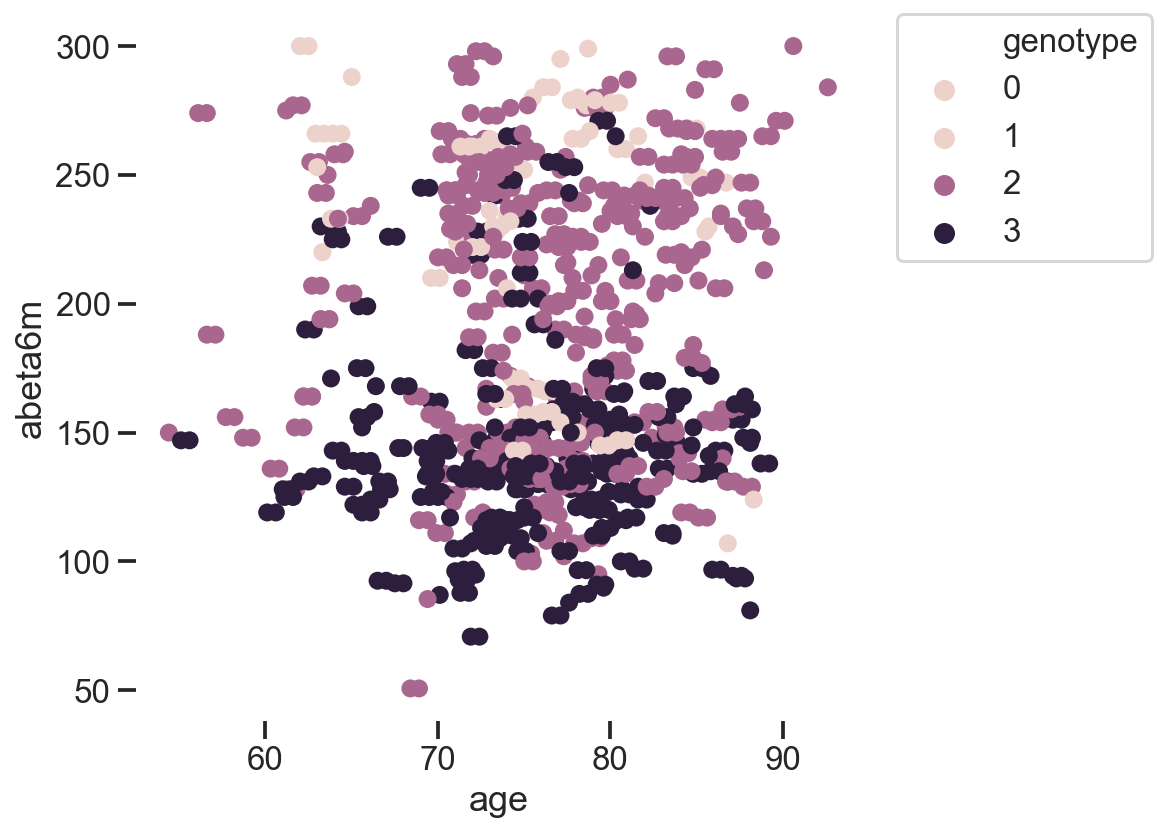

In [1402]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = [3,2,1]
sns.scatterplot(x="age", y="abeta6m",
                hue="genotype",
#                 palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=D, ax=ax);
labels=('Protective factor', 'Risk factor', 'N', '')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()

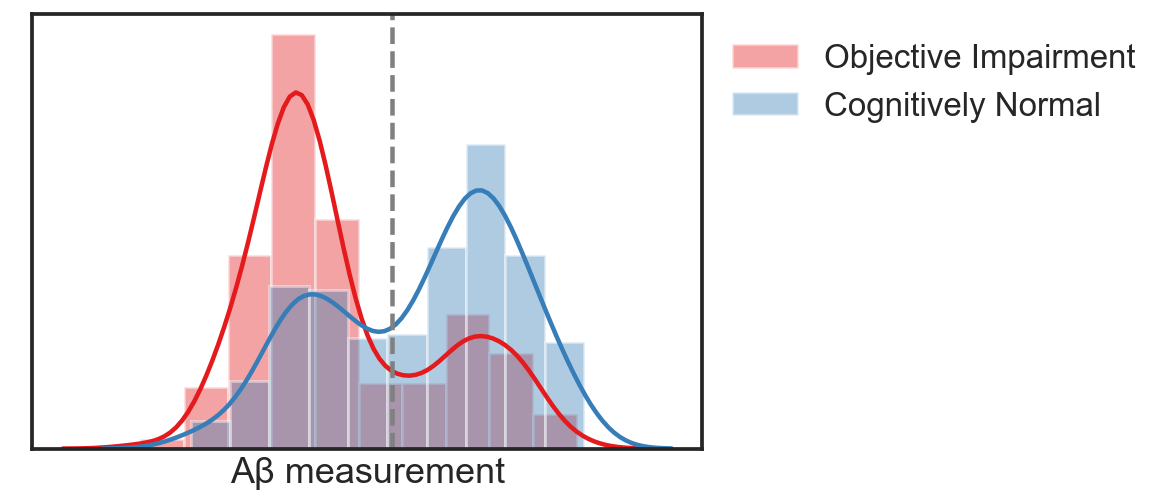

In [1165]:
sns.set_palette('Set1')
nbins = 10
sns.distplot(D.loc[D.dx == 1, 'abeta6m'], bins=nbins, label='Objective Impairment')
sns.distplot(D.loc[D.dx == 0, 'abeta6m'], bins=nbins, label='Cognitively Normal')
plt.axvline(192, ls='--', color='gray')
# plt.title('Amyloid Beta with evidence-based cutoff')
plt.yticks([])
plt.xticks([])
plt.xlabel("Aβ measurement")
plt.legend(bbox_to_anchor=(1, 1), frameon=False);

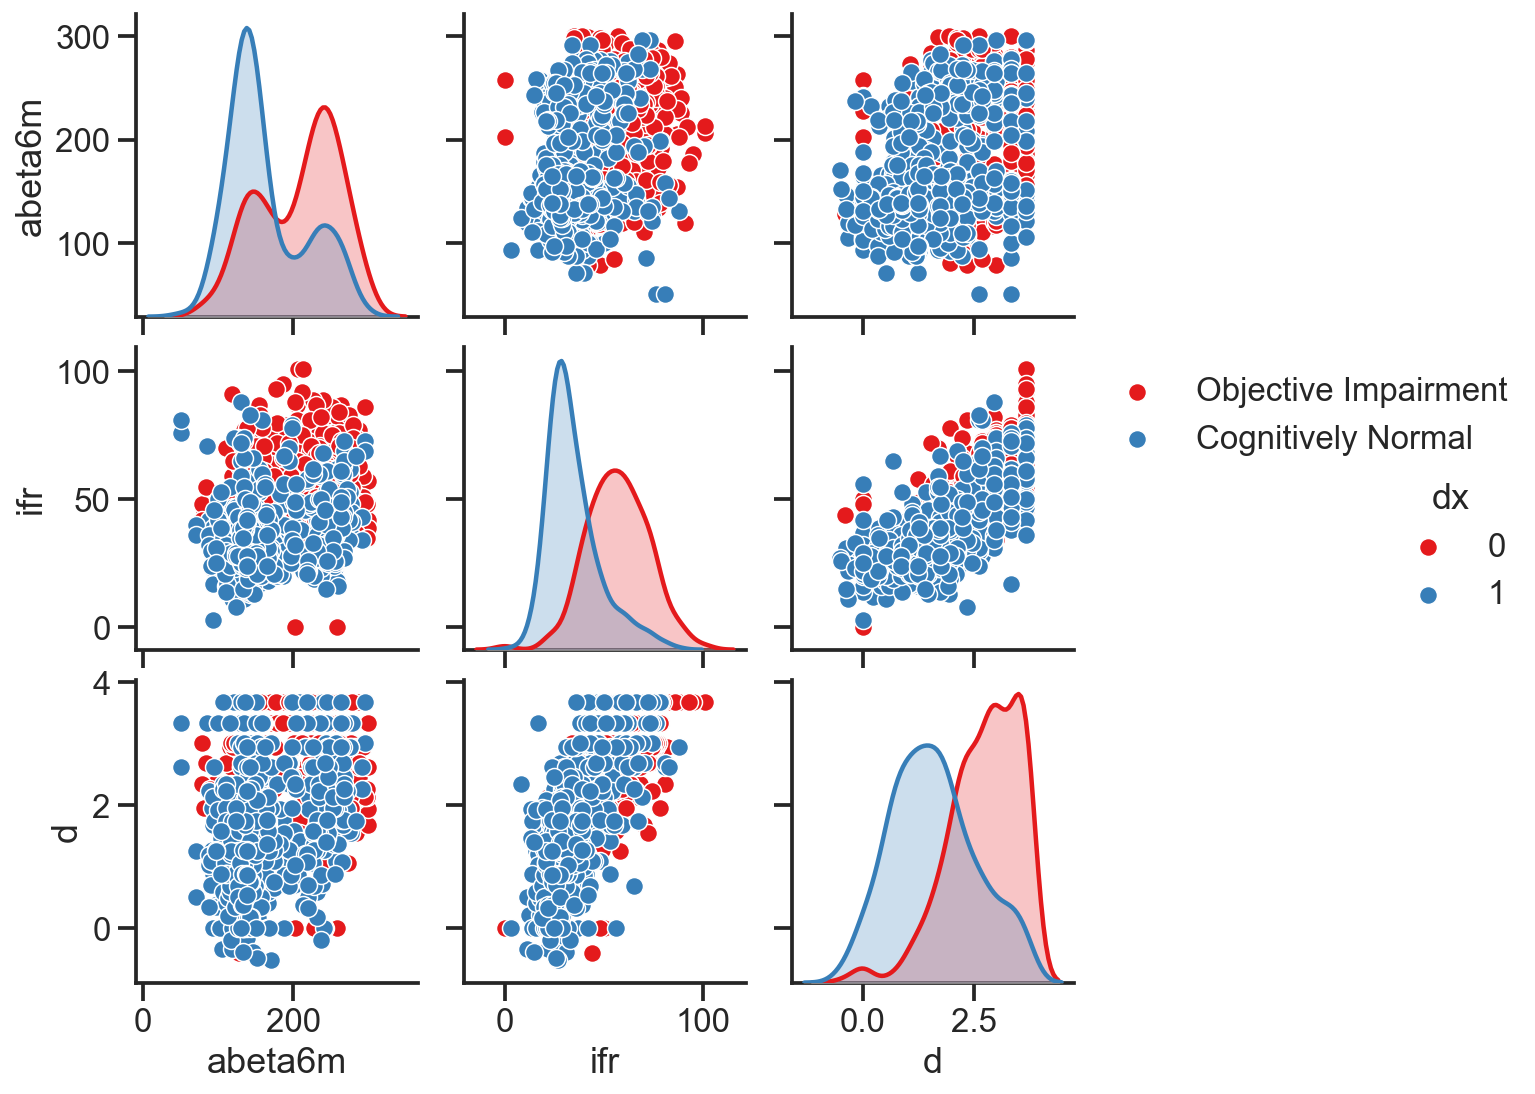

In [1432]:
# plt.legend(bbox_to_anchor=(1, 1), frameon=False);
sns.set_palette('Set1')
sns.pairplot(D[['abeta6m', 'ifr', 'd', 'dx']], hue='dx')
plt.legend(labels=('Objective Impairment', 'Cognitively Normal'),bbox_to_anchor=(1, 1), frameon=False)
plt.show()

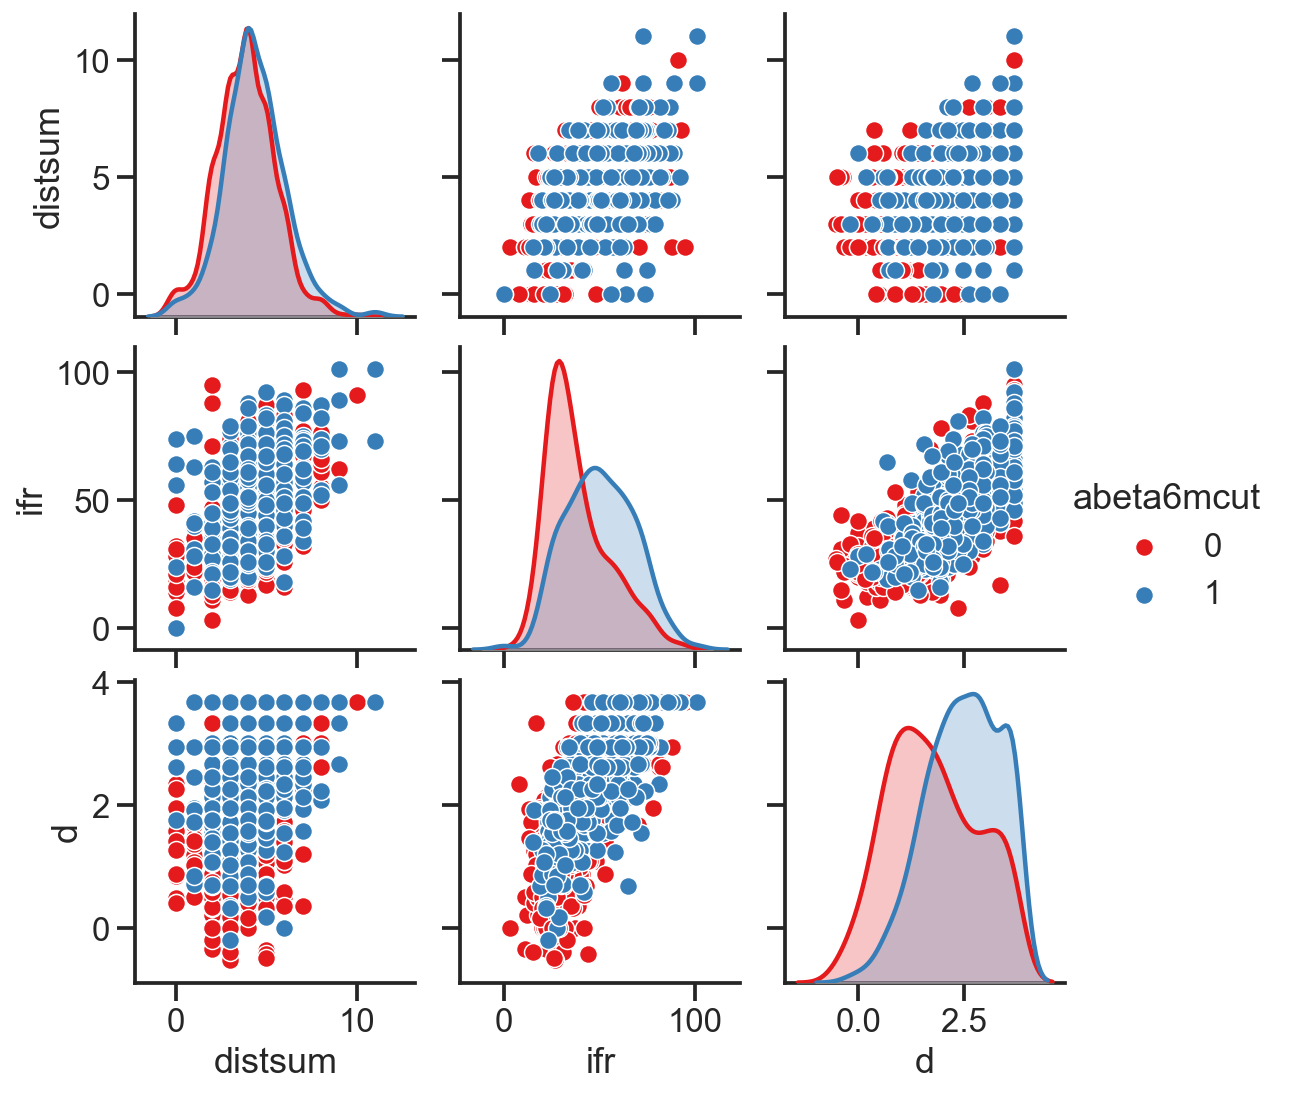

In [1139]:
sns.pairplot(D[['distsum', 'ifr', 'd', 'abeta6mcut']], hue='abeta6mcut')
plt.show()

In [1012]:
# sns.swarmplot(x="age", y="abeta6m", hue="genotype",
#               palette=["g", "y", "r"], data=D)

In [927]:
ct = make_column_transformer(
      (StandardScaler(), ['age', 'edu', 'abeta6m', 'ifr', 'distsum']),
      (OneHotEncoder(), ['genotype']),
    remainder='passthrough')

In [928]:
cols = ['age', 'edu', 'abeta6m', 'ifr', 'distsum',
        'protective_factor', 'neutral_factor', 'risk_factor',
        'rid', 'month', 'sex', 'dx', 'abeta6mcut', 'd', 'beta', 'c', 'ad']
df = pd.DataFrame(ct.fit_transform(D), columns=cols)
cols = pd.Index(['rid', 'month', 'sex', 'age', 'edu', 'dx',
                'abeta6m', 'abeta6mcut',
                'protective_factor', 'neutral_factor', 'risk_factor',
                'ifr', 'distsum',  'd', 'beta', 'c', 'ad'])
df = df.loc[:, cols]
df

,rid,month,sex,age,edu,dx,abeta6m,abeta6mcut,protective_factor,neutral_factor,risk_factor,ifr,distsum,d,beta,c,ad
0,5.0,0.0,0.0,-0.335336,0.003754,0.0,-1.149544,0.0,0.0,1.0,0.0,0.146186,-0.040900,3.335001,0.574077,-0.166414,0.990818
1,5.0,6.0,0.0,-0.260536,0.003754,0.0,-1.149544,0.0,0.0,1.0,0.0,0.034992,-1.260113,3.335001,0.574077,-0.166414,0.990818
2,5.0,12.0,0.0,-0.185735,0.003754,0.0,-0.796566,0.0,0.0,1.0,0.0,0.424170,0.568706,3.335001,0.574077,-0.166414,0.990818
3,8.0,0.0,1.0,1.280358,0.708804,1.0,1.533087,0.0,1.0,0.0,0.0,1.480508,0.568706,3.335001,0.574077,-0.166414,0.990818
4,8.0,6.0,1.0,1.355158,0.708804,1.0,1.533087,0.0,1.0,0.0,0.0,0.535363,1.178313,3.335001,0.574077,-0.166414,0.990818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,1421.0,6.0,1.0,-0.155815,-1.406346,0.0,-0.849513,1.0,0.0,0.0,1.0,-0.465379,1.178313,3.335001,0.574077,-0.166414,0.990818
935,1421.0,12.0,1.0,-0.081014,-1.406346,0.0,-0.761268,1.0,0.0,0.0,1.0,-0.076201,-0.650507,3.335001,0.574077,-0.166414,0.990818
936,1421.0,18.0,1.0,-0.006213,-1.406346,0.0,-0.761268,1.0,0.0,0.0,1.0,-0.854556,-0.040900,3.335001,0.574077,-0.166414,0.990818
937,1423.0,0.0,0.0,-0.978622,1.061329,0.0,-0.743619,1.0,0.0,0.0,1.0,-1.076943,-0.040900,3.335001,0.574077,-0.166414,0.990818


In [1388]:
X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m'], axis=1), df[['abeta6mcut']]
X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m', 'protective_factor', 'neutral_factor', 'risk_factor'], axis=1), df[['abeta6mcut']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train

,sex,age,edu,dx,ifr,distsum,d,beta,c,ad
240,0.0,0.367790,0.003754,1.0,-1.076943,-1.260113,3.335001,0.574077,-0.166414,0.990818
270,1.0,-0.963662,0.003754,0.0,-0.131798,0.568706,3.335001,0.574077,-0.166414,0.990818
760,0.0,-0.350296,1.413854,0.0,0.034992,-0.040900,3.335001,0.574077,-0.166414,0.990818
721,1.0,0.053627,0.708804,1.0,0.590960,0.568706,3.335001,0.574077,-0.166414,0.990818
39,0.0,0.038667,0.003754,0.0,1.758492,1.178313,3.335001,0.574077,-0.166414,0.990818
...,...,...,...,...,...,...,...,...,...,...
835,0.0,1.414999,0.003754,1.0,-0.576572,-1.260113,3.335001,0.574077,-0.166414,0.990818
192,0.0,-0.649499,1.413854,0.0,1.146928,-0.650507,3.335001,0.574077,-0.166414,0.990818
629,0.0,1.235477,-1.053821,1.0,-0.465379,-0.650507,3.335001,0.574077,-0.166414,0.990818
559,0.0,1.175637,-0.348771,0.0,-1.132540,0.568706,3.335001,0.574077,-0.166414,0.990818


# <center>Analysis</center>

In [1389]:
lg = LogisticRegression(random_state=0,  max_iter=1000).fit(X_train, np.ravel(y_train))

In [1390]:
def precision_recall(clf):
    y_score = clf.decision_function(X_test)
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
def show_precision_recall_curve(clf):
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision));

In [1391]:
precision_recall(lg)

Average precision-recall score: 0.92


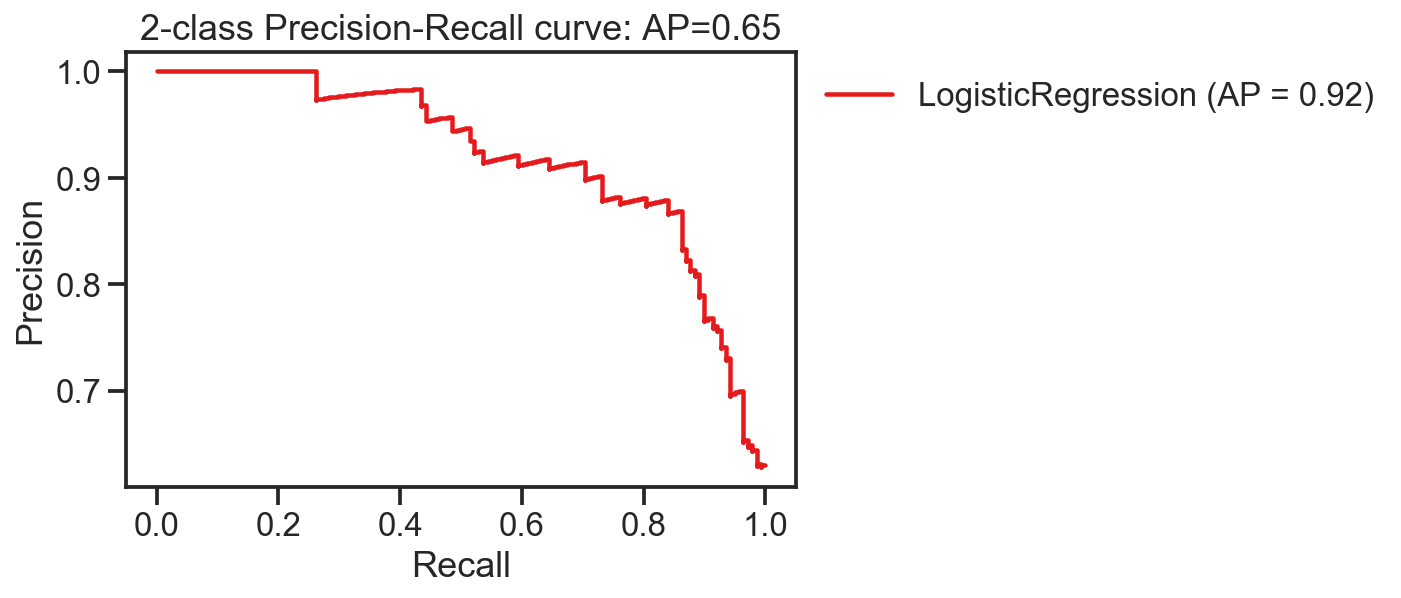

In [1392]:
show_precision_recall_curve(lg)
plt.legend(bbox_to_anchor=(1, 1), frameon=False);

In [1393]:
svc = svm.SVC(random_state=0)
svc.fit(X_train, np.ravel(y_train));

In [1394]:
precision_recall(svc)

Average precision-recall score: 0.92


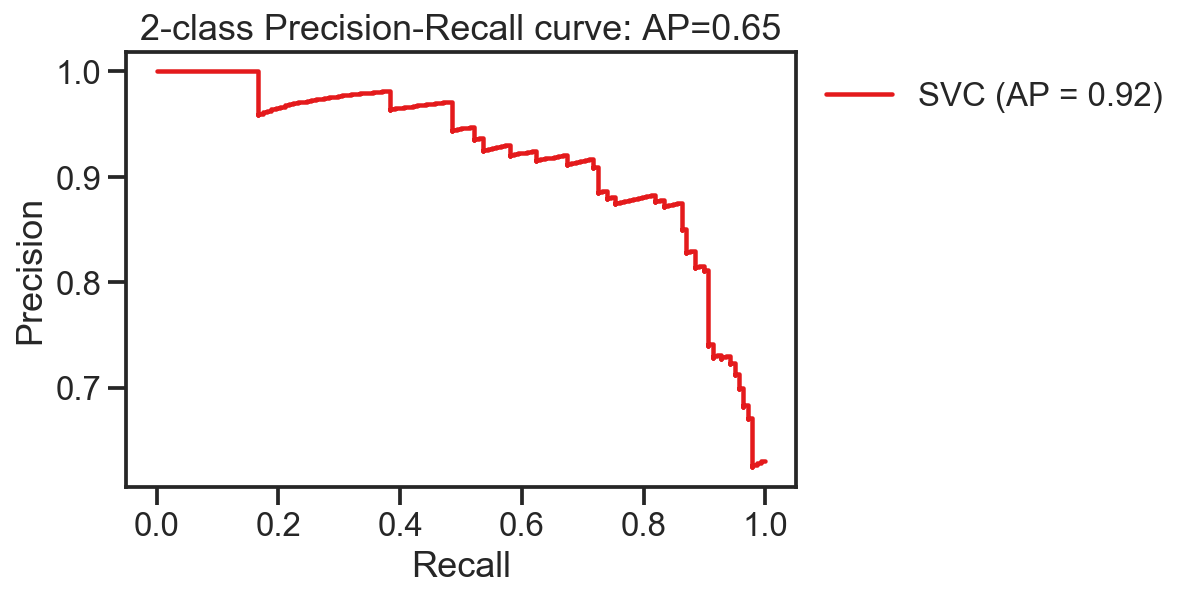

In [1395]:
show_precision_recall_curve(svc)
plt.legend(bbox_to_anchor=(1, 1), frameon=False);

In [1396]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

/Users/alex/miniconda3/envs/cs273a/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1397]:
precision_recall(gbc)

Average precision-recall score: 0.91


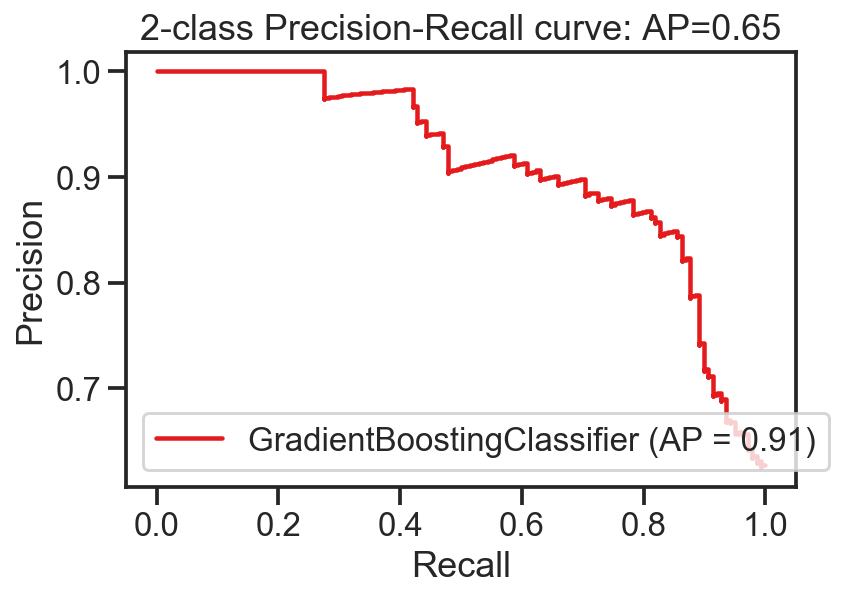

In [1398]:
show_precision_recall_curve(gbc)

In [1399]:
labels = {
    'sex': 'Gender',
    'age': 'Age',
    'edu': 'School Yrs',
    'dx': 'Diagnosis',
    'protective_factor': 'Protective Factor',
    'neutral_factor': 'Neutral Factor',
    'risk_factor': 'Risk Factor',
    'ifr': 'Immediate Free Recall',
    'distsum': 'Total IFR',
    'd': 'Discrimination',
    'beta': 'Bias',
    'c': 'C',
    'ad': 'AD'
}

.

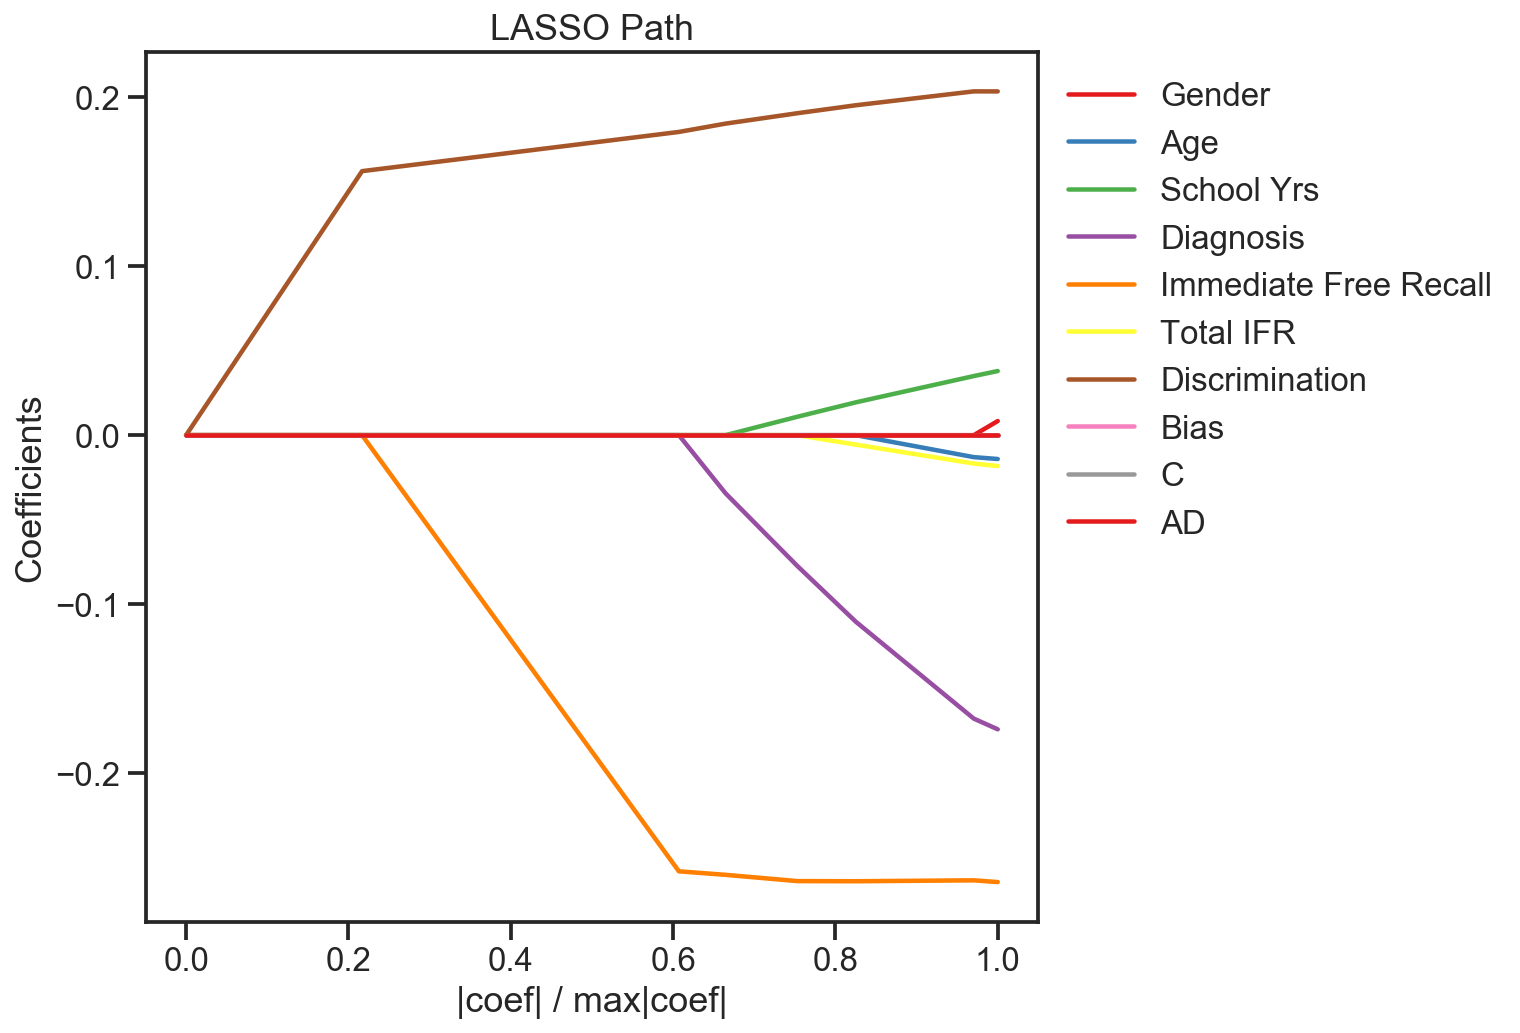

In [1400]:
reg = LassoLars(alpha=.1)
_, _, coefs = lars_path(X.to_numpy(), np.ravel(y), method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.figure(figsize=(8,8))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(labels=[labels.get(x) for x in X.columns.to_numpy()], bbox_to_anchor=(1, 1), frameon=False)
plt.show()

# <center>Future Work</center>

* Interpret coefficients of logistic regression model
* Complete hierarchical signal detection theory model
* Create a probabilistic classifier that includes the demographic data

* Consider longitudinal change in cognitive measurements
* Compare longitudinal cognitive changes to amyloid positivity
* Consider whether cognitive ability mitigates genetic risk in Alzheimer's diagnosis